# Pytorch in the wild

## Data augmentation

### Mixup

In [47]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np

In [41]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
classes = dataset.classes

Files already downloaded and verified


In [42]:
def get_image_by_class(dataset, class_name):
    class_idx = dataset.class_to_idx[class_name]
    for img, label in dataset:
        if label==class_idx:
            return img.unsqueeze(0), label
cat_img, cat_label = get_image_by_class(dataset, "cat") # (1,3,H,W)
dog_img, dog_label = get_image_by_class(dataset, "dog") # (1,3,H,W)
dog_img.shape

torch.Size([1, 3, 32, 32])

In [43]:
# batch size of 2
inputs = torch.cat([cat_img, dog_img]) # (2,3,H,W)
targets = torch.tensor([cat_label, dog_label])

In [44]:
def mixup_data(x, y, alpha=0.5):
    if alpha>0:
        lamb = torch.distributions.beta.Beta(alpha, alpha).sample().item()
    else:
        lamb = 1.0
    batch_size = x.size(0)
    indices = torch.randperm(batch_size) # randperm(5) = [0,3,4,2,1]
    mixed_x = lamb*x+(1-lamb)*x[indices,:]
    y_a, y_b = y, y[indices] # y_a:[cat,dog..]; y_b:[dog,dog..] etc.
    return mixed_x, y_a, y_b, lamb # (2,3,H,W),(2,),(2,),int

mixed_imgs, y_a, y_b, lamb = mixup_data(inputs, targets, alpha=0.4) # 2 rows: cat&dog,0,1,0.3; dog&cat,1,0,0.3

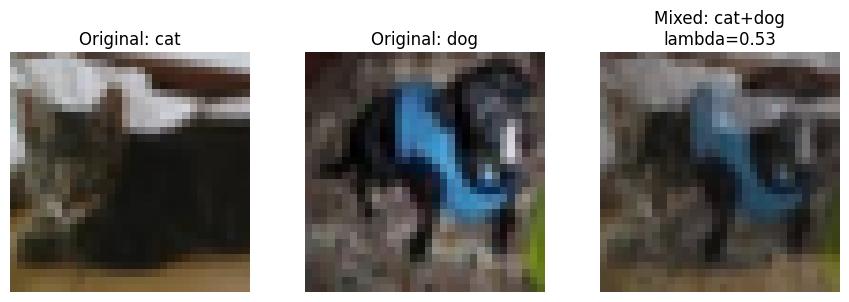

In [45]:
def show_tensor_image(tensor, title=None):
    np_img = tensor.permute(1,2,0).numpy() # (H,W,3)
    np_img = np.clip(np_img,0,1)
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis("off")
    
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
show_tensor_image(inputs[0], f"Original: {classes[targets[0]]}")

plt.subplot(1,3,2)
show_tensor_image(inputs[1], f"Original: {classes[targets[1]]}")

plt.subplot(1,3,3)
show_tensor_image(mixed_imgs[0], f"Mixed: {classes[y_a[0]]}+{classes[y_b[0]]}\nlambda={lamb:.2f}")
plt.tight_layout()
plt.show()